## Imports

In [1]:
import pyopencl as cl
from mcramp import Instrument

import numpy as np

import matplotlib.pyplot as plt
import os

os.environ["PYOPENCL_NO_CACHE"] = "1"
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"

## Constants + Conversions

In [2]:
V2K = lambda v: v*(1.58825361e-3)
E2K = lambda E: np.sqrt(E*(1.0/2.072))
K2E = lambda K: 2.072*(K**2.0)
E2V = lambda E: np.sqrt(E)*437.393377

Ei = 3.2   # Incident energy [meV]
R = 3.5     # Radius of detector [m]
L1 = 1.0    # Distance from moderator to sample [m]
h = 2.0     # Vertical height above horizon of detector [m]

vi = E2V(Ei)
tof_i = L1*1e6 / vi
vi_lo = E2V(Ei - 3.0)
vi_hi = E2V(Ei + 3.0)

tof_f_lo = np.sqrt(R**2.0 + h**2.0)*1e6 / vi_lo # Highest interesting tof
tof_f_hi = R*1e6 / vi_hi                        # Lowest interesting tof

tof_binning = [tof_i + tof_f_hi, 100, tof_i + tof_f_lo]

N = int(1e8)    # Number of trajectories to simulate

theta_binning = [0.0, 1.0, 140]
y_binning = [-h, 0.1, h]

## OpenCL Internals

In [3]:
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

## Vanadium run

In [4]:
inst = Instrument(
        'let_sample_area.json', 
        ctx, 
        queue, 
        Ei=Ei,
        L1=L1,
        height=h,
        radius=R,
        sample=r"'delta.sqw'",
        tof_bin = tof_binning,
        theta_binning = theta_binning,
        y_binning = y_binning
)

inst.execute(N, buf_max_mod = 2)

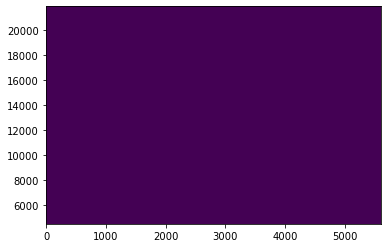

In [5]:
det_img = inst.data()['Detector']
plt.pcolormesh(
    det_img[0], 
    det_img[1], 
    det_img[2]
)
plt.show()

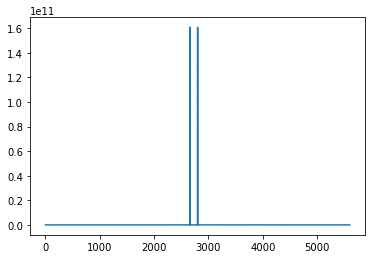

In [6]:
vanadium = det_img[2]
vanadium_int = np.sum(vanadium, axis=0)
plt.plot(vanadium_int)
plt.show()

## Sample run

In [7]:
inst = Instrument(
        'let_sample_area.json', 
        ctx, 
        queue, 
        Ei=Ei,
        L1=L1,
        height=h,
        radius=R,
        sample=r"'delta.sqw'",
        tof_bin = tof_binning,
        theta_binning = theta_binning,
        y_binning = y_binning
)

inst.execute(N, buf_max_mod = 2)

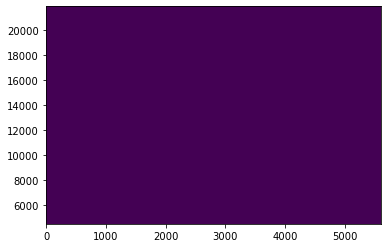

In [8]:
det_img = inst.data()['Detector']
plt.pcolormesh(
    det_img[0], 
    det_img[1], 
    det_img[2]
)
plt.show()

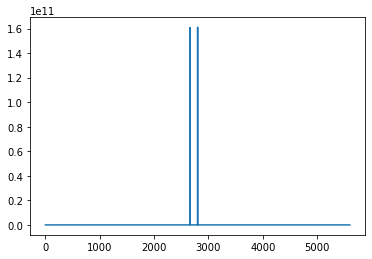

In [9]:
integ = np.sum(det_img[2], axis=0)
plt.plot(integ)
plt.show()

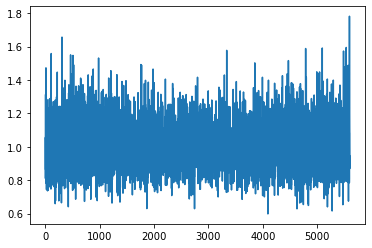

In [10]:
plt.plot(integ / vanadium_int)
plt.show()

The overall trend in the detector number signal is due to the y dependence of solid angle. We see that post vanadium correction, this is removed, so the correction has worked. Now we want to correct the full 2D signal, integrate it, and ensure that this yields the same (as it should)

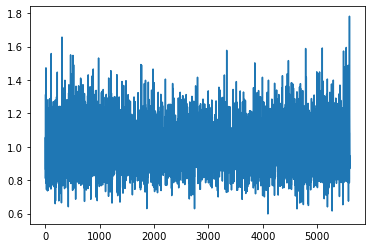

In [11]:
normed_img = np.divide(det_img[2], vanadium_int)
plt.plot(np.sum(normed_img, axis=0))
plt.show()

As expected, these are the same. *normed_img* is now the vanadium corrected He4 data.

## Data reduction

To reduce the *(det_num, tof)* data to *(Q, w)* we need to:

 - Calculate *twotheta* and *y* from detector number
 - Calculate secondary path lengths *L2*
 - Calculate *Ef* from the tof bins and path lengths
 - Calculate *ki* and *kf* from *Ei* and *Ef*
 - Calculate *Q* from *ki*, *kf*, and *twotheta*
 

In [12]:
tof = det_img[1]
detnum = det_img[0]

num_theta_bins = round((theta_binning[-1] - theta_binning[0]) / theta_binning[1])
num_y_bins = round((y_binning[-1] - y_binning[0]) / y_binning[1])

theta = (detnum % num_theta_bins) * theta_binning[1] + theta_binning[0]
y = (detnum // num_theta_bins) * y_binning[1] + y_binning[0]

L2 = np.sqrt(R**2.0 + y**2.0)

vi = E2V(Ei)
ki = E2K(Ei)
kf = V2K(L2 / ((tof - tof_i)*1e-6)) # Tofs from RAMP are in microseconds, convert to seconds here
Ef = K2E(kf)

dE = Ei - Ef
Q = np.sqrt(ki**2.0 + kf**2.0 - 2*ki*kf*np.cos(np.radians(theta)))

Ensure we have recovered the geometric data correctly...

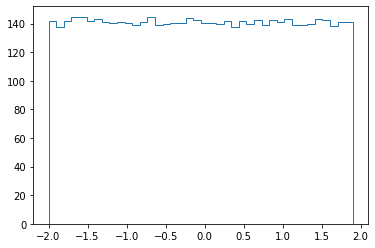

In [13]:
plt.hist(
    y.flatten(), 
    weights=normed_img.flatten(),
    histtype=u'step',
    bins=40
)
plt.show()

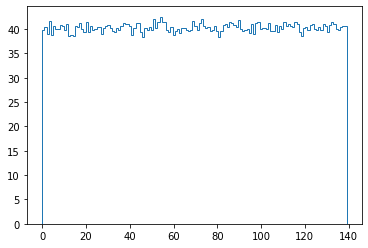

In [14]:
plt.hist(
    theta.flatten(), 
    weights=normed_img.flatten(),
    histtype=u'step',
    bins=140
)
plt.show()

In [15]:
H_van, xe, ye = np.histogram2d(
    Q.flatten(),
    dE.flatten(), 
    weights=vanadium.flatten(),
    bins=(40,40),
    range=((0, 3.0), (-2.5, 2.5))
)
H, _, _ = np.histogram2d(
    Q.flatten(),
    dE.flatten(), 
    weights=det_img[2].flatten(),
    bins=(40,40),
    range=((0, 3.0), (-2.5, 2.5))
)

X, Y = np.meshgrid(xe, ye)

C:\Users\Gino\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


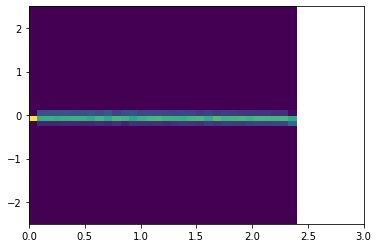

In [17]:
vint = np.sum(H_van, axis=1)
plt.pcolormesh(X, Y, (H.T / vint))